In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

https://www.kaggle.com/para24/xgboost-stepwise-tuning-using-optuna

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
#all_data= pd.concat([train_data, test_data]) #

In [4]:
#y_train = train['Survived']
#y_train.head()
#train_data=df.drop('Survived', axis=1)

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train_data.shape

(891, 12)

In [8]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train_data.dropna(subset=['Embarked'], inplace=True)

In [10]:
train_data.drop(columns=['Name', 'Ticket'], inplace=True)  #'PassengerId'

In [11]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         0
dtype: int64

<AxesSubplot:>

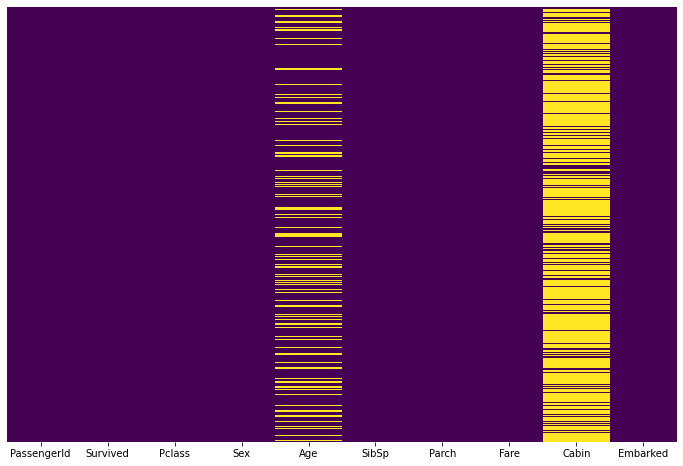

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          712 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Cabin        202 non-null    object 
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.4+ KB


In [14]:
train_data['Cabin'] = train_data['Cabin'].isnull().astype(int) ##
train_data['Cabin'].value_counts()

1    687
0    202
Name: Cabin, dtype: int64

In [15]:
train_data['Age']=train_data['Age'].fillna(train_data['Age'].mean())

<AxesSubplot:>

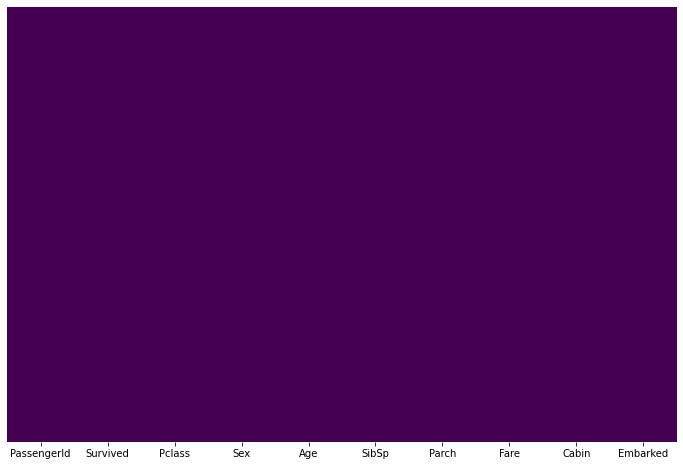

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [17]:
# Nettoyage (preprocessing phase 1) OK pour train_data

In [18]:
# étape réalisée en // pour le test_data que nous allons maintenant charger

In [19]:
categorical_cols = [cname for cname in train_data.columns if train_data[cname].nunique() <30 and train_data[cname].dtype=='object']
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64','float64']]
my_cols = categorical_cols + numerical_cols
train_data = train_data[my_cols]

In [20]:
print(categorical_cols,'\n\n', numerical_cols)

['Sex', 'Embarked'] 

 ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [21]:
train_data.head()

,Sex,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,male,S,1,0,3,22.0,1,0,7.2500
1,female,C,2,1,1,38.0,1,0,71.2833
2,female,S,3,1,3,26.0,0,0,7.9250
3,female,S,4,1,1,35.0,1,0,53.1000
4,male,S,5,0,3,35.0,0,0,8.0500


In [22]:
# Chargement des données test_data
test_data=pd.read_csv('Cleanedtestxgb2580821.csv')

In [23]:
PassengerId = test_data['PassengerId']

In [24]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,7.8292,1,Q
1,893,3,female,47.0,1,0,7.0000,1,S
2,894,2,male,62.0,0,0,9.6875,1,Q
3,895,3,male,27.0,0,0,8.6625,1,S
4,896,3,female,22.0,1,1,12.2875,1,S


In [25]:
# Concatenation des données train_data et test_data avant la phase de preprocessing 2 -> One hot encoding des categorical variables)
final_data2=train_data.merge(test_data, how = 'outer')
# final_data3=train_data.merge(test_data, how = 'inner') KO
final_data2.head()

,Sex,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin
0,male,S,1,0.0,3,22.0,1,0,7.2500,NaN
1,female,C,2,1.0,1,38.0,1,0,71.2833,NaN
2,female,S,3,1.0,3,26.0,0,0,7.9250,NaN
3,female,S,4,1.0,1,35.0,1,0,53.1000,NaN
4,male,S,5,0.0,3,35.0,0,0,8.0500,NaN


In [26]:
final_data2.shape

(1307, 10)

In [27]:
# Test Concatenation des données avec une autre méthode
final_data=pd.concat([train_data,test_data],axis=0)

In [28]:
final_data.head()

,Sex,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin
0,male,S,1,0.0,3,22.0,1,0,7.2500,NaN
1,female,C,2,1.0,1,38.0,1,0,71.2833,NaN
2,female,S,3,1.0,3,26.0,0,0,7.9250,NaN
3,female,S,4,1.0,1,35.0,1,0,53.1000,NaN
4,male,S,5,0.0,3,35.0,0,0,8.0500,NaN


In [29]:
# Verif de la concatenation
final_data.shape

(1307, 10)

In [30]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sex          1307 non-null   object 
 1   Embarked     1307 non-null   object 
 2   PassengerId  1307 non-null   int64  
 3   Survived     889 non-null    float64
 4   Pclass       1307 non-null   int64  
 5   Age          1307 non-null   float64
 6   SibSp        1307 non-null   int64  
 7   Parch        1307 non-null   int64  
 8   Fare         1307 non-null   float64
 9   Cabin        418 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 112.3+ KB


In [31]:
final_data['Sex'].replace(['male','female'],[0,1], inplace=True)

In [32]:
final_data['Fare'] = final_data['Fare'].astype('int')

In [33]:
#final_data['Survived'] = final_data['Survived'].astype('int')
#final_data['Survived'] = pd.to_numeric(final_data['Survived'], errors='coerce')
# final_data[final_data['Survived'].notnull(), 'Survived'] = final_data.loc[final_data['Survived'].notnull(), 'Survived'].apply(int)
final_data['Survived']=final_data['Survived'].astype(np.float).astype("Int32")

In [34]:
final_data.head()

,Sex,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin
0,0,S,1,0,3,22.0,1,0,7,NaN
1,1,C,2,1,1,38.0,1,0,71,NaN
2,1,S,3,1,3,26.0,0,0,7,NaN
3,1,S,4,1,1,35.0,1,0,53,NaN
4,0,S,5,0,3,35.0,0,0,8,NaN


In [35]:
def cat_onehotencoding_multcols(multcolumns):
    data_final = final_data
    i=0
    for fields in multcolumns:
        print(fields)
        df1=pd.get_dummies(final_data[fields],drop_first=True)
        final_data.drop([fields],axis=1,inplace=True)
        if i==0:
            data_final=df1.copy()
        else:
            data_final=pd.concat([data_final,df1],axis=1)
        i=i+1
    data_final=pd.concat([final_data,data_final],axis=1)
    return data_final

In [36]:
columns = ['Embarked']

final_data=cat_onehotencoding_multcols(columns)

Embarked


In [37]:
final_data.head(1)

,Sex,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Q,S
0,0,1,0,3,22.0,1,0,7,NaN,0,1


In [38]:
final_data.describe()

,Sex,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Q,S
count,1307.000000,1307.000000,889.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,418.000000,1307.000000,1307.000000
mean,0.355011,655.319816,0.382452,2.296863,29.843736,0.499617,0.385616,32.798776,0.782297,0.094109,0.699311
std,0.478700,377.922205,0.486260,0.836942,12.861061,1.042273,0.866092,51.753983,0.413179,0.292092,0.458733
min,0.000000,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,328.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000
50%,0.000000,655.000000,0.000000,3.000000,29.642093,0.000000,0.000000,14.000000,1.000000,0.000000,1.000000
75%,1.000000,982.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000
max,1.000000,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.000000,1.000000,1.000000,1.000000


In [39]:
final_data.drop(columns=['Cabin'], inplace=True)
final_data.head(1)

,Sex,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Q,S
0,0,1,0,3,22.0,1,0,7,0,1


In [40]:
train_df=final_data.iloc[:889,:]
test_df=final_data.iloc[889:,:]

In [41]:
test_df.drop(['Survived'],axis=1,inplace=True)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [42]:
train_df.shape

(889, 10)

In [43]:
test_df.shape

(418, 9)

In [44]:
from xgboost import XGBClassifier
model_1=XGBClassifier(n_estimators=1000, learning_rate= 0.05, n_jobs=-1, random_state=0)

In [45]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

In [46]:
model_1.fit(X_train, y_train)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
import pickle
filename = 'model1_250821.pkl'
pickle.dump(model_1, open(filename, 'wb'))

In [48]:
y_pred=model_1.predict(test_df)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [49]:
output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_pred})
output.to_csv('my_submission2508.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


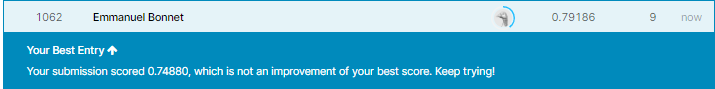

In [50]:
##Create Sample Submission file and Submit
pred=pd.DataFrame(y_pred)
sub_df=pd.read_csv('my_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('my_submissionx2508.csv',index=False)

KeyError: 'Id'

In [ ]:
# à reprendre

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', dtype=np.int))])

## Column Transformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns),('cat', categorical_transformer, categorical_columns)])


In [ ]:
## Applying Column Transformer
final_data = preprocessor.fit_transform(final_data)
#x_test = preprocessor.transform(x_test)

## Label encoding
#y_trans = LabelEncoder()
#y_train = y_trans.fit_transform(y_train)
#y_test = y_trans.transform(y_test)

In [ ]:
## Save feature names after one-hot encoding for feature importances plots
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_columns))
feature_names = feature_names + numeric_columns

In [ ]:
final_data =pd.DataFrame(final_data)
final_data

In [ ]:
# def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[all_data[c].unique(), len(all_data[c].unique()), all_data[c].isnull().sum()] for c in all_data.columns]
    df_temp = pd.DataFrame(data, index=df.columns,columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]

#def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        all_data[col] = all_data[col].astype('category')
    return df

In [ ]:
# summarize_categoricals(all_data, show_levels=True)

In [ ]:
# columns with N° of unique values < 10 (whatever its is int64 or object inside raw datas)
all_data = to_categorical(['Pclass', 'Sex','SibSp', 'Parch', 'Cabin', 'Embarked'], all_data)

In [ ]:
# Data Preprocessing

In [ ]:
x = all_data.iloc[:, 1:]
y = df['Survived']

categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
categorical_columns, numeric_columns

In [ ]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True, stratify=y)
x_train, x_val, y_train, y_val = data_splits

list(map(lambda x: x.shape, [x, y, x_train, x_val, y_train, y_val]))

In [ ]:
#One-hot Encoding and Standardization

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int))
])

## Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


## Applying Column Transformer
x_train = preprocessor.fit_transform(x_train)
x_val = preprocessor.transform(x_val)


## Label encoding
y_trans = LabelEncoder()
y_train = y_trans.fit_transform(y_train)
y_val = y_trans.transform(y_val)


## Save feature names after one-hot encoding for feature importances plots
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_columns))# 1 # # 2 # 3 #
feature_names = feature_names + numeric_columns

In [ ]:
# 1 # Attribue Column Transformer : property named_transformers_
# Access the fitted transformer by name.Read-only attribute to access any transformer by given name. 
# Keys are transformer names and values are the fitted transformer objects.

# 2 # Attributes pipeline : named_steps
# -> Dictionary-like object, with the following attributes. Read-only attribute to access any step parameter by user given name. 
# Keys are step names and values are steps parameters.

# 3 # Attributes feature_extraction : .get_feature_names()

In [ ]:
x_train.shape

In [ ]:
print(x_train)

In [ ]:
print(x_val)

In [ ]:
print(feature_names)

In [ ]:
#Utility Functions

In [ ]:
# 5. XGBoost with default parameters

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn import metrics

In [ ]:
primary_eval_metric = metrics.f1_score
confusion_lbs = ['Not Survived', 'Survived']

## Compute `class_weights` using sklearn
cls_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)

In [ ]:
xgb_clf_default = XGBClassifier(scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_default.fit(x_train, y_train);

xgb_clf_default, xgb_report_default = report(xgb_clf_default, x_train, y_train,
                                             x_val, y_val,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

In [ ]:
test_data.dropna(subset=['Embarked'], inplace=True)

In [ ]:
test_data.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

In [ ]:
test_data['Cabin'] = test_data['Cabin'].isnull().astype(int)
test_data['Cabin'].value_counts()

In [ ]:
summarize_categoricals(test_data, show_levels=True)

In [ ]:
# columns with N° of unique values < 10 (whatever its is int64 or object inside raw datas)
test_data = to_categorical(['Pclass', 'Sex','SibSp', 'Parch', 'Cabin', 'Embarked'], test_data)

In [ ]:
x_test = test_data.iloc[:,1:]

categorical_columns = list(x_test.select_dtypes(include='category').columns)
numeric_columns = list(x_test.select_dtypes(exclude='category').columns)

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int))
])

## Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

## Applying Column Transformer
x_test = preprocessor.fit_transform(x_test)


In [ ]:
print(x_test.shape)

In [ ]:
xgb_clf_default.predict(x_test)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('my_submissionxx.csv', index=False)
#print("Your submission was successfully saved!")

## What is Optuna?
Optuna is one of the optimization libraries that use Sequential Model Based Optimization (SMBO). Conventional optimization approaches like Grid search and Random search do not make use of the information available regarding the previously explored hyperparameter search space. Unlike those techniques, SMBO techniques use the historical exploration information to make a more informed decision regarding the direction in which the optimizer should explore next in the search space. Such a mechanism gives SMBO techniques an edge over the conventional approaches in terms of convergence speed.

Advantages of SMBO:

Requires fewer iterations/ trials to converge, even if the search space is very huge.

Search is more focused in the region of the search space that is closer to the true optimal point.

Facilitates pausing and continuing the optimization process.

Some examples of SMBO based optimization libraries:- Skopt, Hyperopt, Optuna

Advantages of Optuna over Hyperopt and Skopt:

Provides support storing the optimization information in a database. Hence, facilitates saving and resuming the optimization process, unlike Hyperopt and Skopt.

The interface and documentation is more mature than Skopt and Hyperopt.

# 7. Stepwise Hyperparameter Tuning
The stepwise algorithm for XGBoost hyperparameter tuning is inspired by a similar algorithm for LightGBM explained in this post.

The most commonly used and the most effective XGBoost parameters are split into 3 groups:

GROUP 1: max_depth , min_child_weight

GROUP 2: subsample, colsample_bytree

GROUP 3: learning_rate, num_boost_round

Initially, learning_rate and num_boost_round are fixed at 0.1 and 1000 respectively.

Each of these groups of hyperparameters are tuned sequentially. While tuning a particular group, all the subsequent groups are fixed at default or initial values and all the preceding groups are fixed at the values obtained after the tuning process. For example, by the time execution reachs GROUP 2, GROUP 1 is already tuned so we will fix GROUP 1 at the optimal values obtained, while the parameters in the subsequent groups (only GROUP 3 in this case) are left default or at the intialized values (0.1 and 1000 in this case) since they still need to be tuned.

The benefit of stepwise tuning is that the hyperparameter space is narrowed down to the group being tuned. In conventional tuning methods, we tune all the hyperparameters togeather which requires searching through a larger space. For instance, in this case we have 6 hyperparameters, tuning all of them together will involve searching through a 6 dimensional space. However, if stepwise algorithm is used, we will have to search a space of only 2 dimensions at once which is way more efficient and faster than searching through a larger space.

In [ ]:
import xgboost as xgb
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback


def objective(trial, X, y, group, score, params=dict()):
    dtrain = xgb.DMatrix(X, label=y)
    class_weight = (y.shape[0] - np.sum(y)) / np.sum(y)
    
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform('min_child_weight',
                                                              1e-10, 1e10)
    
    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0, 1)
    
    if group == '3':
        params['learning_rate'] = trial.suggest_uniform('learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100, 1000)

    pruning_callback = XGBoostPruningCallback(trial, "test-" + score.__name__)
    cv_scores = xgb.cv(params, dtrain, nfold=5,
                       stratified=True,
                       feval=score,
                       early_stopping_rounds=10,
                       callbacks=[pruning_callback],
                       seed=0)

    return cv_scores['test-' + score.__name__ + '-mean'].values[-1]
  
def execute_optimization(study_name, group, score, trials,
                         params=dict(), direction='maximize'):
    logging.set_verbosity(logging.ERROR)
    
    ## We use pruner to skip trials that are NOT fruitful
    pruner = MedianPruner(n_warmup_steps=5)
    
    study = create_study(direction=direction,
                         study_name=study_name,
                         storage='sqlite:///optuna.db',
                         load_if_exists=True,
                         pruner=pruner)

    study.optimize(lambda trial: objective(trial, x_train, y_train,
                                           group, score, params),
                   n_trials=trials,
                   n_jobs=-1)
    
    
    print("STUDY NAME: ", study_name)
    print('------------------------------------------------')
    print("EVALUATION METRIC: ", score.__name__)
    print('------------------------------------------------')
    print("BEST CV SCORE", study.best_value)
    print('------------------------------------------------')
    print(f"OPTIMAL GROUP - {group} PARAMS: ", study.best_params)
    print('------------------------------------------------')
    print("BEST TRIAL", study.best_trial)
    print('------------------------------------------------')
    
    
    return study.best_params



In [ ]:
score_func = metrics.f1_score
def score_function(y_pred, dtrain):
    y_pred = (y_pred > 0.5).astype(int)
    y_true = (dtrain.get_label() > 0.5).astype(int)
    return score_func.__name__, score_func(y_true, y_pred)

score_function.__name__ = score_func.__name__

In [ ]:
def stepwise_optimization(trials=10):
    final_params = dict()
    for g in ['1', '2', '3']:
        print(f"=========================== Optimizing Group - {g} ============================")
        update_params = execute_optimization('xgboost', g, score_function, trials,
                                             params=final_params, direction='maximize')
        final_params.update(update_params)
        print(f"PARAMS after optimizing GROUP - {g}: ", final_params)
        print()
        print()

    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    
    return final_params

In [ ]:
params = stepwise_optimization()

In [ ]:
params

In [ ]:
xgb_clf_tuned_1 = XGBClassifier(**params, scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_tuned_1.fit(x_train, y_train);

xgb_clf_tuned_1, xgb_report_tuned_1 = report(xgb_clf_tuned_1, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

# Resuming the optimization process in Optuna
Since the classifier is still overfitting, we can continue/ resume the optimization process just by running the optimization process again on the same study by passing the study name and storage location to the study_name and storage arguments of the create_study method (see execute_optimization function).

Since I am calling the from the execute_optimization function from the stepwise_optimization function, we just have to execute the stepwise_optimization function once more but with more trails.

In [ ]:
params = stepwise_optimization(trials=50)

In [ ]:
params

In [ ]:
xgb_clf_tuned_2 = XGBClassifier(**params, scale_pos_weight=cls_weight,
                                random_state=0, n_jobs=-1)
xgb_clf_tuned_2.fit(x_train, y_train);

xgb_clf_tuned_2, xgb_report_tuned_2 = report(xgb_clf_tuned_2, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

# Model Comparison

In [ ]:
report_list = [xgb_report_default, xgb_report_tuned_1, xgb_report_tuned_2]
clf_labels = ['XGBoost with default params',
              'XGBoost after 10 trials',
              'XGBoost after 50 more trials',]

In [ ]:
compare_table, compare_plot = compare_models(y_test, clf_reports=report_list,
                                             labels=clf_labels,
                                             score=primary_eval_metric.__name__)

compare_table